In [227]:
import numpy as np
from scipy import misc
import glob
import imageio
from PIL import Image
import skimage
from keras.models import Model,Input
from keras.layers import *
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
import pickle

In [228]:
imgs = glob.glob('DATA/*.jpg')
height,width = imageio.imread(imgs[0]).shape[:2]
center_height = int((height - width) / 2)
print(height,width)

250 250


In [229]:
with open('new_data.pkl', 'rb') as f:
    data = pickle.load(f)
print(data["smily"])

0      -1.091407
1      -1.826037
2       0.766886
3      -0.971679
4       0.106412
          ...   
4036    1.151181
4037    0.652186
4038   -0.725584
4039   -0.769613
4040    1.529314
Name: smily, Length: 4041, dtype: float64


In [316]:
# hyper parameters
total_epoch = 3
batch_size = 64
img_dim = 64
z_dim = 512

In [269]:
def imread(f):
    x = Image.open(f)
    x = x.resize((img_dim, img_dim), Image.ANTIALIAS)
    x = np.asarray(x)
    x = x.astype(np.float32) / 255 * 2 - 1
    return x

In [315]:
def data_generator(bs=64):
    X = []
    Y = np.random.rand(64,3)
    while True:
        np.random.shuffle(imgs)
        for f in imgs:
            X.append(imread(f))
            if len(X) == bs:
                X = np.array(X)
                yield [X,Y],None
                X = []

In [310]:
A = data_generator(bs=3)
#print(*A, sep='\n') # * will unpack the generator

In [197]:
# Encoder
x_image = Input(shape=(img_dim, img_dim, 3))
x = x_image
x = Conv2D(int(z_dim/16), kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(int(z_dim/8), kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(int(z_dim/4), kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(int(z_dim/2), kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(z_dim, kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = GlobalAveragePooling2D()(x)

#x_c = Input(shape=(3,))
#pre_out = concatenate([x,x_c])
#x = Dense(z_dim, activation='linear')(pre_out)
#encoder = Model([x_image,x_c],x)

encoder = Model(x_image,x)
encoder.summary()
map_size = K.int_shape(encoder.layers[-2].output)[1:-1]


Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_136 (InputLayer)       [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization_294 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_210 (LeakyReLU)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_295 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_211 (LeakyReLU)  (None, 16, 16, 64)        0  

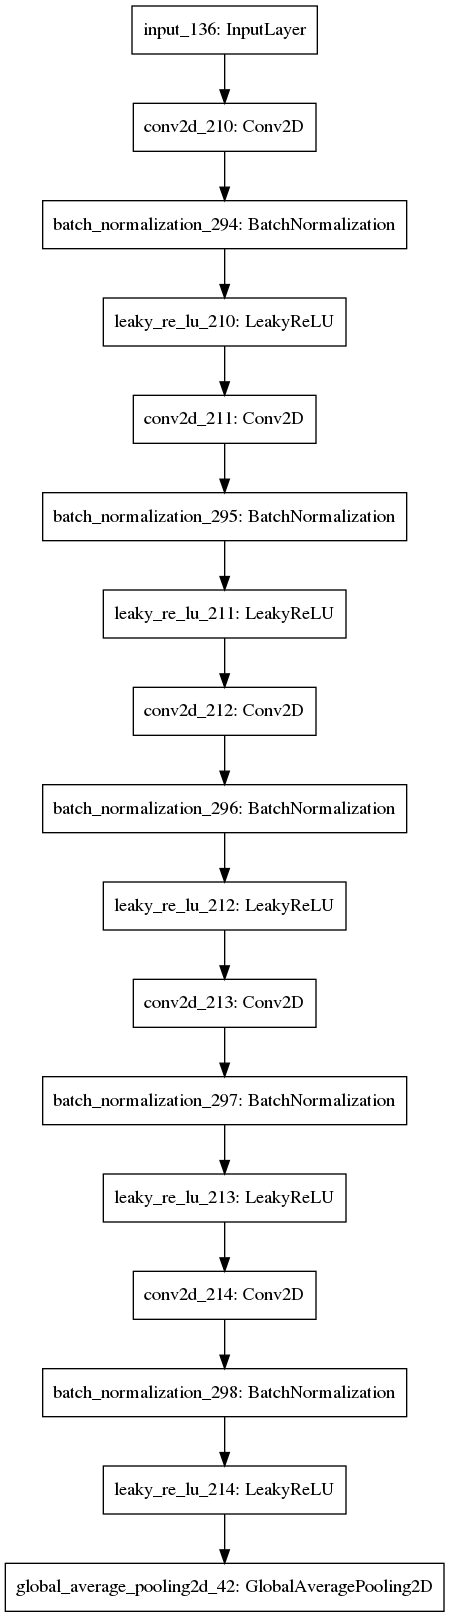

In [198]:
plot_model(encoder, to_file='encoder.png')

In [199]:
# Decoder

z_c = Input(shape=(3,))
z_in = Input(shape=K.int_shape(x)[1:])
pre_out = concatenate([z_in,z_c])

z = pre_out
z = Dense(np.prod(map_size)*z_dim)(z)
z = Reshape(map_size + (z_dim,))(z)
z = Conv2DTranspose(z_dim/2, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Conv2DTranspose(z_dim/4, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Conv2DTranspose(z_dim/8, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Conv2DTranspose(z_dim/16, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = Activation('tanh')(z)

decoder = Model([z_in,z_c], z)
decoder.summary()

Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_138 (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_137 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
concatenate_41 (Concatenate)    (None, 515)          0           input_138[0][0]                  
                                                                 input_137[0][0]                  
__________________________________________________________________________________________________
dense_129 (Dense)               (None, 2048)         1056768     concatenate_41[0][0]      

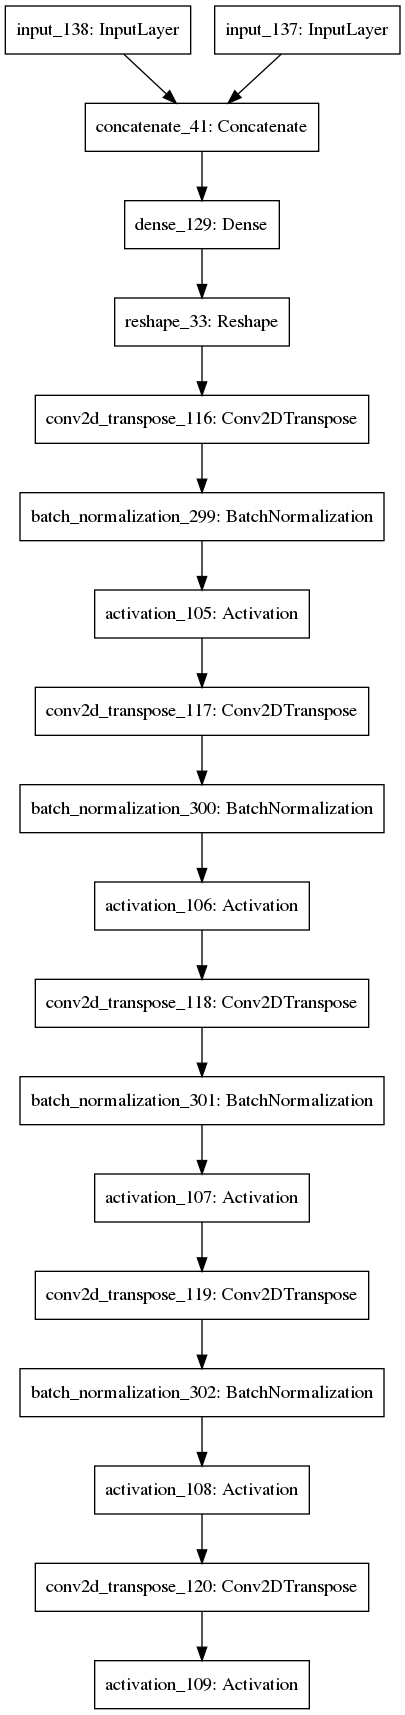

In [200]:
plot_model(decoder, to_file='decoder.png')

In [201]:
class ScaleShift(Layer):
    def __init__(self, **kwargs):
        super(ScaleShift, self).__init__(**kwargs)
    def call(self, inputs):
        z, shift, log_scale = inputs
        z = K.exp(log_scale) * z + shift
        logdet = -K.sum(K.mean(log_scale, 0))
        self.add_loss(logdet)
        return z

In [301]:
z_shift = Dense(z_dim)(x)
z_log_scale = Dense(z_dim)(x)
u = Lambda(lambda z: K.random_normal(shape=K.shape(z)))(z_shift)
z = ScaleShift()([u, z_shift, z_log_scale])

x_recon = decoder([z,z_c])
x_out = Subtract()([x_image, x_recon])

#LOSS NEED TO BE CHANGED
recon_loss = 0.5 * K.sum(K.mean(x_out**2, 0)) + 0.5 * np.log(2*np.pi) * np.prod(K.int_shape(x_out)[1:])
z_loss = 0.5 * K.sum(K.mean(z**2, 0)) - 0.5 * K.sum(K.mean(u**2, 0))
vae_loss = recon_loss + z_loss

vae = Model([x_image,z_c], x_out)
plot_model(vae, to_file='vae.png')

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(1e-4))



In [302]:
def sample(path):
    n = 9
    figure = np.zeros((img_dim*n, img_dim*n, 3))
    for i in range(n):
        for j in range(n):
            x_recon = decoder.predict(np.random.randn(1, *K.int_shape(x)[1:]))
            digit = x_recon[0]
            figure[i*img_dim: (i+1)*img_dim,
                   j*img_dim: (j+1)*img_dim] = digit
    figure = (figure + 1) / 2 * 255
    figure = figure.astype(np.uint8)
    imageio.imwrite(path, figure)

In [303]:
class Evaluate(Callback):
    def __init__(self):
        import os
        self.lowest = 1e10
        self.losses = []
        if not os.path.exists('VAE_samples'):
            os.mkdir('VAE_samples')
        with open('VAE_samples/architecture.json', 'w') as f:
            f.write(decoder.to_json())
    def on_epoch_end(self, epoch, logs=None):
        path = 'VAE_samples/test_%s.png' % epoch
        sample(path)
        self.losses.append((epoch, logs['loss']))
        if logs['loss'] <= self.lowest:
            self.lowest = logs['loss']
            decoder.save_weights('VAE_samples/best_encoder.weights')

In [ ]:
evaluator = Evaluate()

vae.fit_generator(data_generator(),
                  epochs=total_epoch,
                  steps_per_epoch=int(len(imgs)/batch_size),
                  callbacks=[evaluator]
                 )

Epoch 1/3
46/63 [====================>.........] - ETA: 9s - loss: 12514.8271 